In [3]:
import itertools
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from omegaconf import OmegaConf

In [4]:
def find_config_files(root_dir):
    for file in os.listdir(root_dir):
        file_path = os.path.join(root_dir, file)
        if file == 'config.yaml':
            yield file_path
        elif os.path.isdir(file_path) and not file.startswith('.'):
            for config_file in find_config_files(file_path):
                yield config_file

def get_config_value(config, key):
    if '.' in key:
        key_parts = key.split('.')
        subconfig = config
        # import pdb; pdb.set_trace()
        for part in key_parts:
            if part in subconfig:
                subconfig = subconfig[part]
            else:
                return None
        return subconfig
    else:
        return config.get(key)


In [ ]:
def plot_loss_vs_parameter(configs, param_names):
    time_stamp = 0
    for key in configs.keys():
        key_lists = key.split('/')
        time_stamp = str(key_lists[2])

    param_values = {}
    for param_name in param_names:
        param_values[param_name] = set(get_config_value(config, param_name) for config in configs.values())

    trailing_averages = {}
    for param_values_combination in itertools.product(*param_values.values()):
        matching_configs = {}
        for config_path, config in configs.items():
            if all(get_config_value(config, param_name) == param_value for param_name, param_value in zip(param_names, param_values_combination)):
                matching_configs[config_path] = config

        if not matching_configs:
            continue

        trailing_avg_values = []
        for config_path, _ in matching_configs.items():
            loss_path = os.path.join(config_path, 'loss_curves.csv')
            if os.path.exists(loss_path):
                loss_df = pd.read_csv(loss_path)
                trailing_avg = loss_df['centered_test_losses'].min()
                trailing_avg_values.append(trailing_avg)

        param_values_tuple = tuple(param_values_combination)
        trailing_averages[param_values_tuple] = sum(trailing_avg_values) / len(trailing_avg_values)

    # Create subplots
    n = len(param_names)
    fig, axs = plt.subplots(n, n, figsize=(15, 15))
    fig.suptitle('Mean Trailing Avg. Validation Loss vs. Parameters')

    for i in range(n):
        for j in range(n):
            if i != j:
                x_param = param_names[i]
                y_param = param_names[j]
                data = []
                for key, value in trailing_averages.items():
                    data.append({
                        x_param: key[i],
                        y_param: key[j],
                        'Mean Trailing Avg. Validation Loss': value
                    })
                df = pd.DataFrame(data)
                sns.scatterplot(x=x_param, y='Mean Trailing Avg. Validation Loss', hue=y_param, data=df, ax=axs[i, j])
                axs[i, j].set_xlabel(f"{x_param}")
                axs[i, j].set_ylabel("Mean Trailing Avg. Validation Loss")
            else:
                axs[i, j].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join(os.getcwd()+"/analysis/figures/", "val_loss_on_[" + str(time_stamp) + "].png"))
    plt.show()


In [ ]:
configs = {}
for file_path in find_config_files('../logs/'):
    with open(file_path, 'r') as f:
        data = yaml.safe_load(f)
        # Do something with the data
        configs[os.path.dirname(file_path)] = OmegaConf.create(data)


In [4]:
def plot_loss_vs_parameter_hydra(configs):
    '''
    Note:
        hydra sweepers rename the sub folder into the job name(i.e. the name of variables)
        which can directly be used as keys for searching information in config.yaml files.
    Args:
        configs: dict of config.yaml in selected log directories
        param_names: arguments on x-axis
    Return:
        None
    Files:
        saved plogs
    '''

    # for hydra jobs, the name of variables can be defined in folder names
    param_names = []
    time_stamp = 0
    for key in configs.keys():
        key_lists = key.split('/')
        time_stamp = str(key_lists[2])
        varaibles = key_lists[-1].split(',')
        for val in varaibles:
            val_name = val.split('=')
            param_names.append(val_name[0])

    # remove duplicated items from variables
    param_names = [*set(param_names)]



    param_values = {}
    for param_name in param_names:
        param_values[param_name] = set(get_config_value(config, param_name) for config in configs.values())

    # import pdb; pdb.set_trace()

    # Compute trailing averages for each combination of parameter values
    '''
    Format of trailing_averages
        (arg_1, arg_2, ... , arg_n): validation loss
        in which the name of arg_1 ~ arg_n corresponds to param_names

    Transform trailing_averages into more informative way for subplotting:
        each item in dictionary `details_subplots` contains a sub dictionary:{
            'x_axis_name': value from param_names,
            'x_axis_value': value from params_values,
            'legend_name': another value from param_names,
            'legend_value': another value from params_values,
            'val_loss': the average of val_losses from experiments that satisfy the information above
        }
    '''

    details_subplots = {}
    # for each variable for x-axis
    for param_name in param_names:
        # for each value for x-axis variable
        for param_value in param_values[param_name]:
             details_subplots[(param_name, param_value)] = dict()

    # import pdb; pdb.set_trace()

    # for each variable for x-axis
    for param_name in param_names:
        # for each value for x-axis variable
        for param_value in param_values[param_name]:
            # for each possible legend
            for legend_param in param_names:
                if legend_param == param_name:
                    continue

                # legend_values is a list for all possible values under legend_param
                legend_values = [*param_values[legend_param]]
                for legend_val in legend_values:
                    matching_configs = {}
                    for config_path, config in configs.items():
                        if get_config_value(config, param_name) == param_value and get_config_value(config, legend_param) == legend_val:
                            matching_configs[config_path] = config

                    if not matching_configs:
                        continue

                    trailing_avg_values = []
                    for config_path, _ in matching_configs.items():
                        loss_path = os.path.join(config_path, 'loss_curves.csv')
                        if os.path.exists(loss_path):
                            loss_df = pd.read_csv(loss_path)
                            num_worms = len(os.listdir(config_path)) - 3 # Subtract 3 for .hydra, config.yaml, and loss_curves.csv
                            trailing_avg = loss_df['centered_test_losses'].mean()
                            trailing_avg_values.append(trailing_avg)

                    # import pdb; pdb.set_trace()

                    details_subplots[(legend_param, legend_val)][(param_name, param_value)] = {
                        'x_axis_name': param_name,
                        'x_axis_value': param_value,
                        'legend_name': legend_param,
                        'legend_value': legend_val,
                        'val_loss': sum(trailing_avg_values) / len(trailing_avg_values),
                    }


    n_subplots = len(param_names) * (len(param_names) - 1)
    # Plot subfigures
    fig, axs = plt.subplots(len(param_names), len(param_names) - 1, sharex=False, figsize=(2 * len(param_names), 2 * (len(param_names) - 1)))



    for i, param_name in enumerate(param_names):
        axs[i, 0].set_ylabel('Mean Trailing Avg. Validation Loss')
        for (name, val), sub_dict in details_subplots.items():
            x_values = []
            y_values = []
            if name == param_name:
                for (sub_name, sub_val), unit_dict in sub_dict.items():
                    axs[i, 0].set_xlabel(sub_name)
                    axs[i, 0].set_title("Validation Loss of different " + sub_name)

                if len(x_values) == 0:
                    x_values.append([unit_dict['x_axis_value'] for (sub_name, sub_val), unit_dict in sub_dict.items()])
                y_values.append([unit_dict['val_loss'] for (sub_name, sub_val), unit_dict in sub_dict.items()])
                # import pdb; pdb.set_trace()

                axs[i, 0].plot(np.array(x_values).T, np.array(y_values).T)


        legend_values = []
        for (name, val), sub_dict in details_subplots.items():
            if name == param_name:
                legend_values.append(f'{name}:{val}')
        axs[i].legend(legend_values)

    # Display the plot
    plt.savefig(os.path.join(os.getcwd()+"/analysis/figures/", "val_loss_on_[hydra_" + str(time_stamp) + "].png"))
    plt.show()

In [5]:
#!/usr/bin/env python
# encoding: utf-8

from analysis._utils import *
from analysis._pkg import *

def analysis(config: DictConfig,):
    configs = {}
    for file_path in find_config_files(config.analysis.dir):
        with open(file_path, 'r') as f:
            data = yaml.safe_load(f)
            # Do something with the data
            configs[os.path.dirname(file_path)] = OmegaConf.create(data)


    # import pdb; pdb.set_trace()
    # print(get_config_value(configs['../logs/hydra/2023_03_30_16_59_28'], 'preprocess.smooth'))
    # print(get_config_value(configs['../logs/hydra/2023_03_30_16_59_28'], 'model.type'))

    # print(os.getcwd())
    # print(type(configs), len(configs))

    # d = configs['logs/hydra/2023_04_03_20_53_10/dataset.name=Uzel2022,globals.shuffle=True,train.epochs=50']
    # print(type(d))
    # print(OmegaConf.to_yaml(d))

    plot_loss_vs_parameter_hydra(configs)


    # plotting predictions
    for log_dir in configs:
        with open(os.path.join(log_dir + "/config.yaml"), 'r') as f:
            yaml_file = yaml.safe_load(f)
            plot_targets_predictions(
                log_dir,
                "worm1",
                "AVAL",
                get_config_value(yaml_file, 'global.use_residuals'),
            )



config: analysis:
  dir: ../logs/hydra/2023_04_08_21_02_28
  param: None




AttributeError: 'numpy.ndarray' object has no attribute 'set_ylabel'

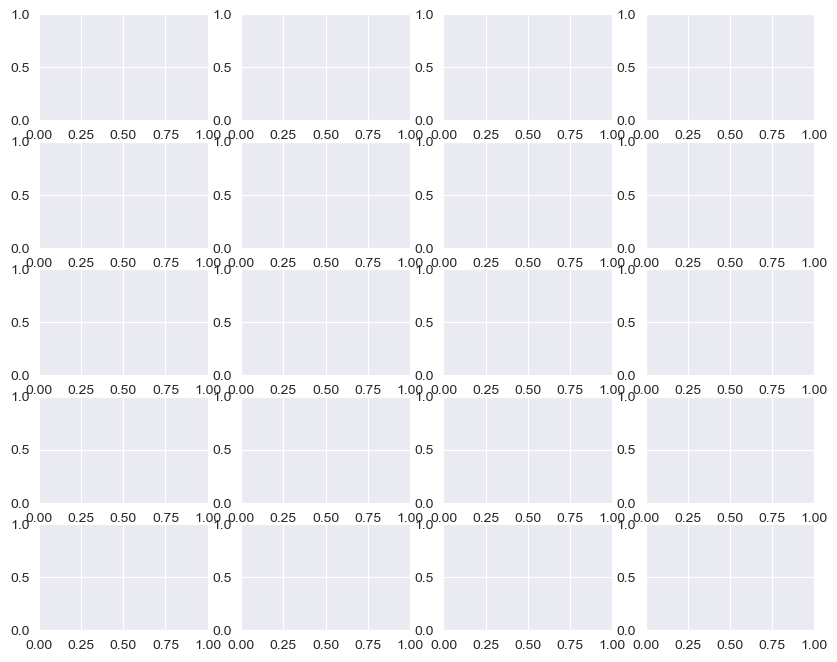

In [6]:
config = OmegaConf.load("../conf/analysis.yaml")
print("config:", OmegaConf.to_yaml(config), end="\n\n")
analysis(config)
